In [1]:
# Importing all the Necessary Packages
import os
import geopandas as gpd
from keplergl import KeplerGl
from rasterio.plot import show
import rasterio as rio
import pycrs

In [2]:
folder_path = 'data'
file_name = 'remote_sensing_challenge_AOI.geojson'

file_path = os.path.join(folder_path, file_name)
aoi_data = gpd.read_file(file_path, driver = 'GeoJSON')
aoi_data

,id,full_id,osm_id,osm_type,cables,frequency,gez,layer,name,operator,power,ref,voltage,wires,line,disused,circuits,location,endpoint:busbar,geometry
0,1,w166885638,166885638,way,3,50,,,,Stromnetz Berlin,line,806,110000,single,,,,,,"MULTIPOLYGON (((13.53442 52.53548, 13.53289 52..."


In [59]:
def assertCRSValues(crs1,crs2):
    assert crs1 == crs2, 'CRS Values are not matching, please reproject to maintain similar CRS!'

In [60]:
aoi_data.dtypes

id                    int64
full_id              object
osm_id               object
osm_type             object
cables               object
frequency            object
gez                  object
layer                object
name                 object
operator             object
power                object
ref                  object
voltage              object
wires                object
line                 object
disused              object
circuits             object
location             object
endpoint:busbar      object
geometry           geometry
dtype: object

In [61]:
# Checking the crs of the data
aoi_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
aoi_data_32633 = aoi_data.copy()
aoi_data_32633 = aoi_data_32633.to_crs(epsg=32633)
print(aoi_data_32633.crs)
aoi_data_32633.to_file(r'data\remote_sensing_challenge32633_AOI.geojson', driver = 'GeoJSON')

epsg:32633


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'data\\remote_sensing_challenge32633_AOI.geojson'

<AxesSubplot:>

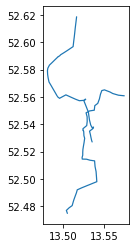

In [7]:
aoi_data.plot()

# Checking the Location of the Data using Kepler GL

In [8]:
base_map = KeplerGl(height=600, width=800)
base_map.add_data(data=aoi_data.copy(), name = 'area_of_interest')
base_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

# Processing the Raster Data (Merged - 13 Bands)

In [9]:
raster_folder_path = r'data'
raster_file_name = r'mergedBandswithSCL.tif'
raster_file = os.path.join(raster_folder_path, raster_file_name)
sat_raster12 = rio.open(raster_file)

In [10]:
print('Data type of the file imported',type(sat_raster12))
print('Number of bands in the TIF file is ',sat_raster12.count)
print('CRS is', sat_raster12.crs)

Data type of the file imported <class 'rasterio.io.DatasetReader'>
Number of bands in the TIF file is  13
CRS is EPSG:32633


# Clipping the Raster Data with the AOI

In [11]:
aoi_geom = aoi_data.at[0,'geometry']

In [12]:
type(aoi_geom)

shapely.geometry.multipolygon.MultiPolygon

In [13]:
envelope = aoi_geom.envelope

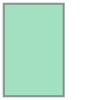

In [14]:
envelope

In [15]:
con_hull = aoi_geom.convex_hull

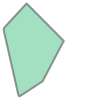

In [16]:
con_hull

In [17]:
aoi_data_boundary = aoi_data.copy()

In [18]:
aoi_data_boundary.at[0,'geometry'] = con_hull
base_map_1 = KeplerGl(height=600, width=800)
base_map_1.add_data(data=aoi_data_boundary.copy(), name = 'area_of_interest')
base_map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

In [19]:
aoi_data_boundary.at[0,'geometry'] = envelope
base_map_1 = KeplerGl(height=600, width=800)
base_map_1.add_data(data=aoi_data_boundary.copy(), name = 'area_of_interest')
base_map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

In [20]:
aoi_data_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
aoi_data_boundary.dtypes

id                    int64
full_id              object
osm_id               object
osm_type             object
cables               object
frequency            object
gez                  object
layer                object
name                 object
operator             object
power                object
ref                  object
voltage              object
wires                object
line                 object
disused              object
circuits             object
location             object
endpoint:busbar      object
geometry           geometry
dtype: object

In [22]:
type(aoi_data_boundary)

geopandas.geodataframe.GeoDataFrame

In [23]:
aoi_data_boundary = aoi_data_boundary.to_crs(sat_raster12.crs)

In [24]:
aoi_data_boundary.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [26]:
coords = getFeatures(aoi_data_boundary)
print(type(coords))
print(coords)

<class 'list'>
[{'type': 'Polygon', 'coordinates': [[[396803.9492745674, 5814881.937933052], [403179.0821638094, 5814751.976428645], [403497.1630042527, 5830853.458352127], [397142.98107521195, 5830983.243710982], [396803.9492745674, 5814881.937933052]]]}]


In [29]:
from rasterio.mask import mask
out_img, out_transform = mask(dataset=sat_raster12, shapes=coords, crop=True)

# Copying the MetaData

In [30]:
# Copy the metadata
out_meta = sat_raster12.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 4758, 'height': 4758, 'count': 13, 'crs': CRS.from_epsg(32633), 'transform': Affine(23.076923076923077, 0.0, 300000.0,
       0.0, -23.076923076923077, 5900040.0)}


In [31]:
sat_raster12.crs.data

{'init': 'epsg:32633'}

In [32]:
epsg_code = int(sat_raster12.crs.data['init'][5:])
print(epsg_code)

32633


In [44]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

In [45]:
with rio.open(r'data\clippedGeoTIFF.tif', "w", **out_meta) as dest:
        dest.write(out_img)

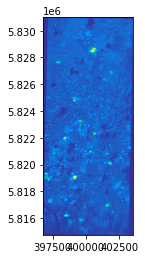

<AxesSubplot:>

In [51]:
clipped = rio.open(r'data\clippedGeoTIFF_32633.tif')

# Visualize
show((clipped, 5), cmap='terrain')

In [58]:
assertCRSValues(clipped.crs,sat_raster12.crs)

In [52]:
clipped.crs

CRS.from_epsg(32633)

In [50]:
type(clipped)

rasterio.io.DatasetReader

In [49]:
lidar_dem_wgs84 = clipped.rasterio.reproject(sat_raster12.crs)

AttributeError: 'DatasetReader' object has no attribute 'rasterio'

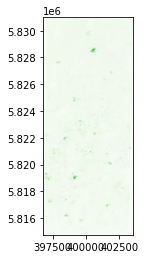

<AxesSubplot:>

In [38]:
from rasterio.plot import show
show(clipped.read(3),cmap='Greens', transform=clipped.transform)